In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'DKK'
share_name = 'STG.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2015-09-30,1741,-910,831,139,291,0,3093,4590,0,...,0,8,0,1177,3311,5542,467,-48,100.00,2015-11-09
1,2015-12-31,1767,-945,822,174,609,0,2999,4827,0,...,0,0,0,1153,3338,5546,389,-64,100.00,2016-03-05
2,2016-03-31,1499,-760,739,138,406,790,3107,4677,4388,...,327,0,2,938,3292,5326,-148,-60,99.87,2016-05-10
3,2016-06-30,1699,-860,840,208,364,799,3034,4522,4450,...,338,0,0,953,3423,5502,452,-87,99.87,2016-08-24
4,2016-09-30,1740,-943,797,152,632,662,2893,4471,4441,...,371,0,0,1063,3088,5258,671,-51,99.87,2016-11-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)

## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
32,2023-09-30,2023-11-09,86.67,2269,-1176,1092,351,54,1118,3544,...,16484,578,0,35,1666,4001,6973,694,-75,6.848087
33,2023-12-31,2024-03-05,86.67,2275,-1186,1089,268,100,964,3270,...,15853,508,0,59,1551,3657,6419,534,-87,6.933528
34,2024-03-31,2024-04-29,85.37,1948,-1067,881,125,103,998,3508,...,16328,487,0,56,1679,3834,6807,-71,-58,6.863684
35,2024-06-30,2024-08-19,84.35,2365,-1256,1109,296,89,1038,3506,...,16428,401,0,58,1481,4807,7547,246,-74,6.927251
36,2024-09-30,2024-11-11,83.08,2430,-1304,1126,297,65,1185,3685,...,16802,481,0,86,2781,4020,8104,355,-69,6.793809


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2016-02-08,56.123013,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.610568,0.389432,0.0,0.0,0.0,0.0,0.477312,0.079839,0.0,0.0
1,2016-02-15,56.684235,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.610568,0.389432,0.0,0.0,0.0,0.0,0.477312,0.079839,0.0,0.0
2,2016-02-22,56.010754,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.610568,0.389432,0.0,0.0,0.0,0.0,0.477312,0.079839,0.0,0.0
3,2016-02-29,56.459740,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.610568,0.389432,0.0,0.0,0.0,0.0,0.477312,0.079839,0.0,0.0
4,2016-03-07,59.602619,2015-12-31,1767,0.0,89.98,100.0,0.0,0.0,609,...,0.618674,0.381326,0.0,0.0,0.0,0.0,0.465195,0.098472,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2016-02-08,56.123013,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.0,0.477312,0.079839,0.0,0.0,inf,0.645909,inf,inf,inf
1,2016-02-15,56.684235,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.0,0.477312,0.079839,0.0,0.0,inf,0.652368,inf,inf,inf
2,2016-02-22,56.010754,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.0,0.477312,0.079839,0.0,0.0,inf,0.644617,inf,inf,inf
3,2016-02-29,56.459740,2015-09-30,1741,0.0,86.89,100.0,0.0,0.0,291,...,0.0,0.477312,0.079839,0.0,0.0,inf,0.649784,inf,inf,inf
4,2016-03-07,59.602619,2015-12-31,1767,0.0,89.98,100.0,0.0,0.0,609,...,0.0,0.465195,0.098472,0.0,0.0,inf,0.662399,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

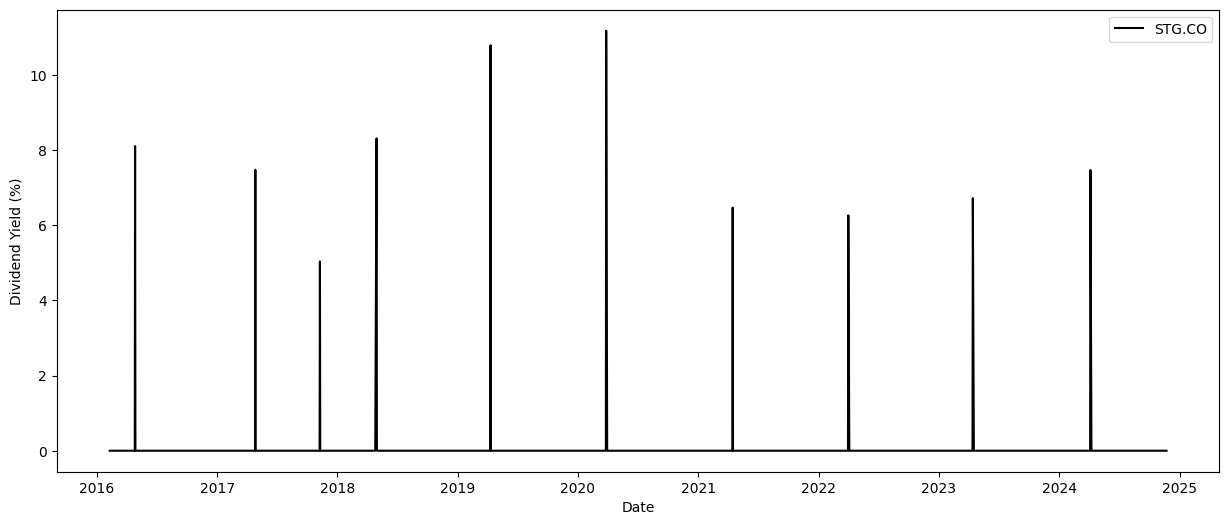

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.300352
share_price      1.000000
Name: share_price, dtype: float64


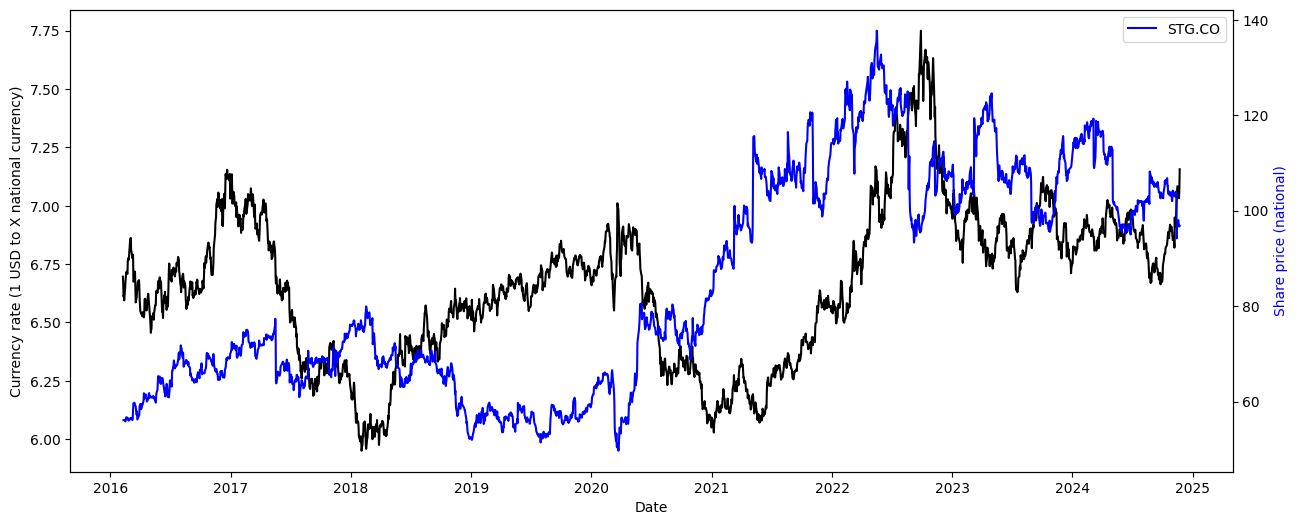

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

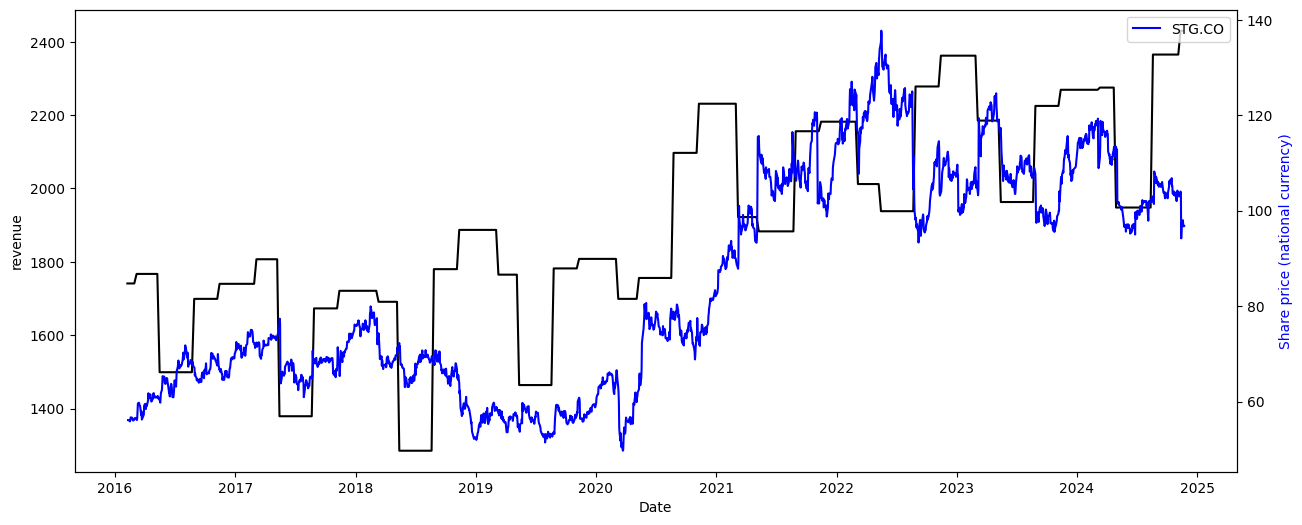

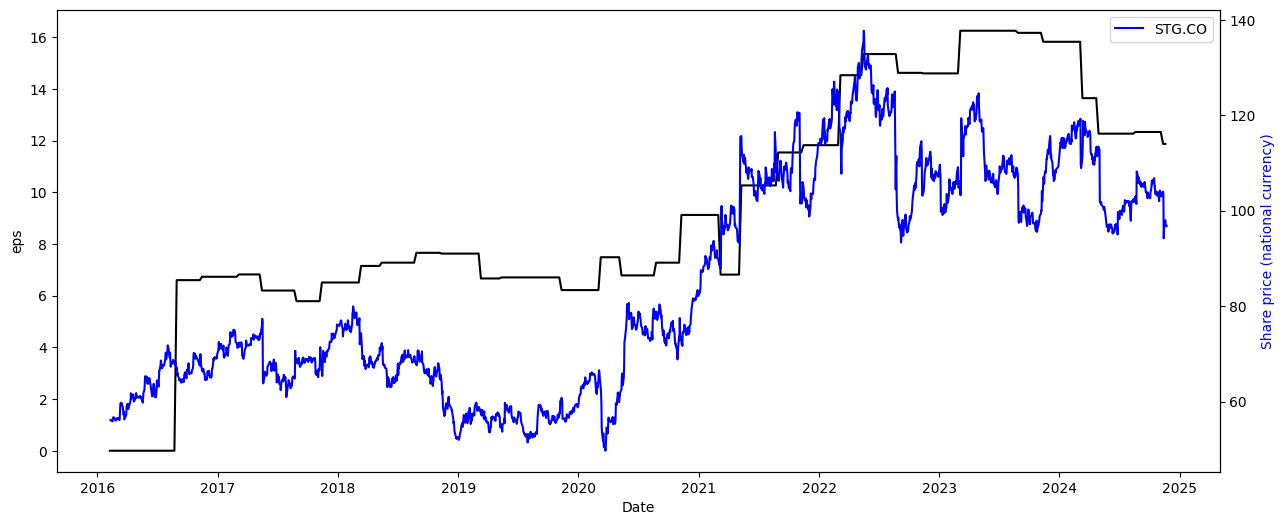

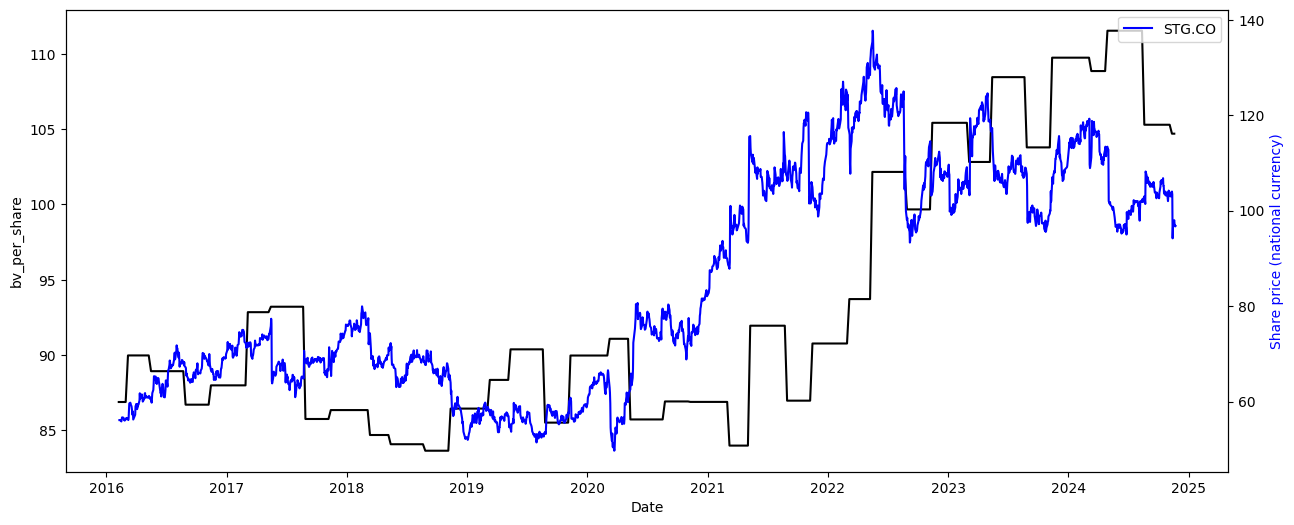

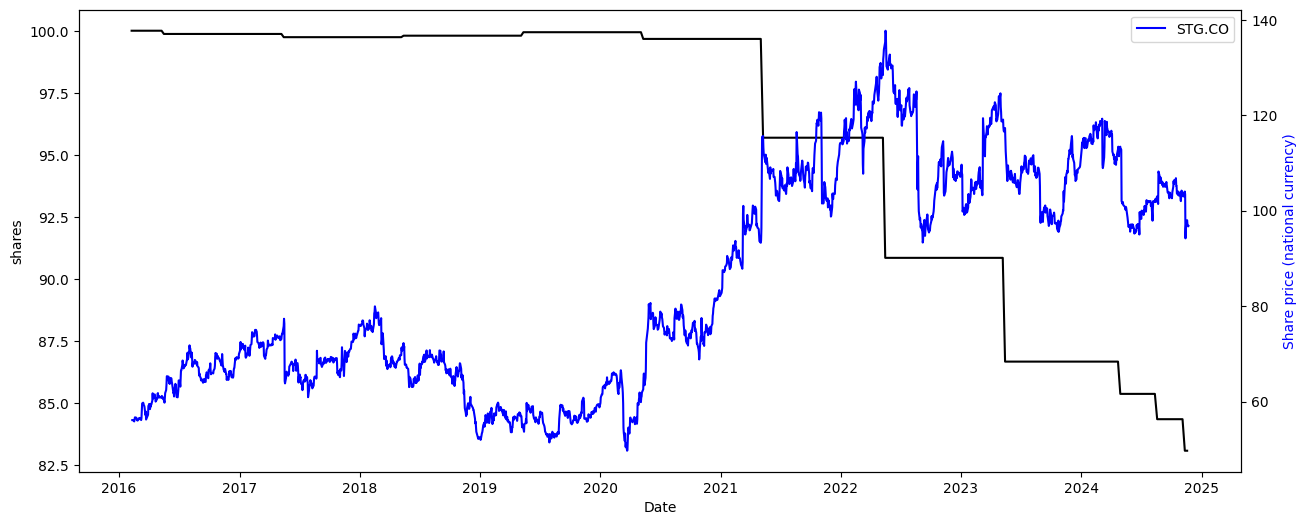

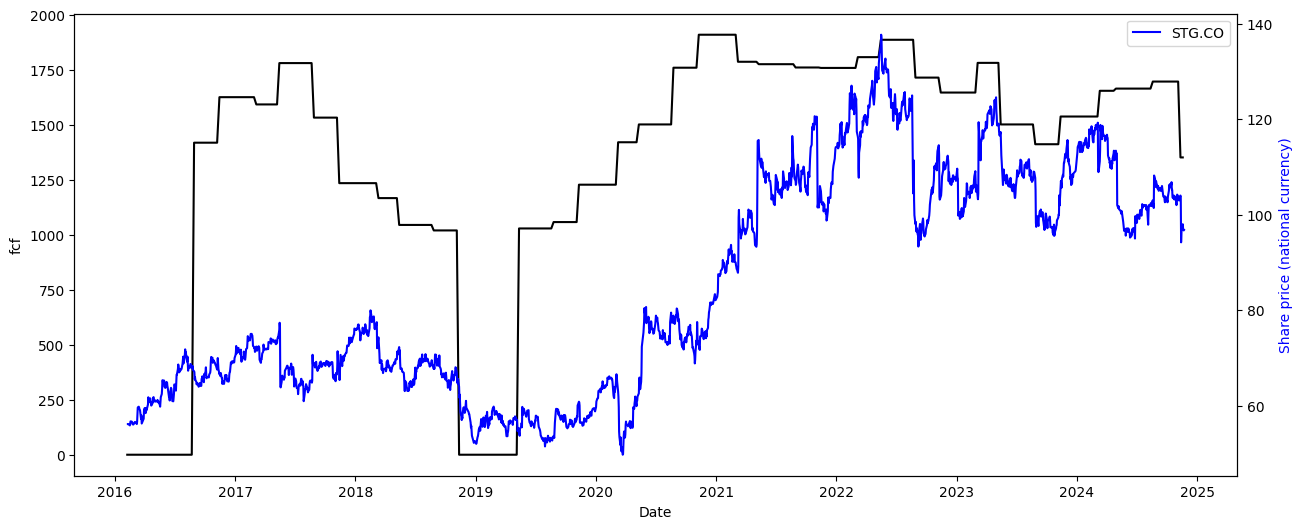

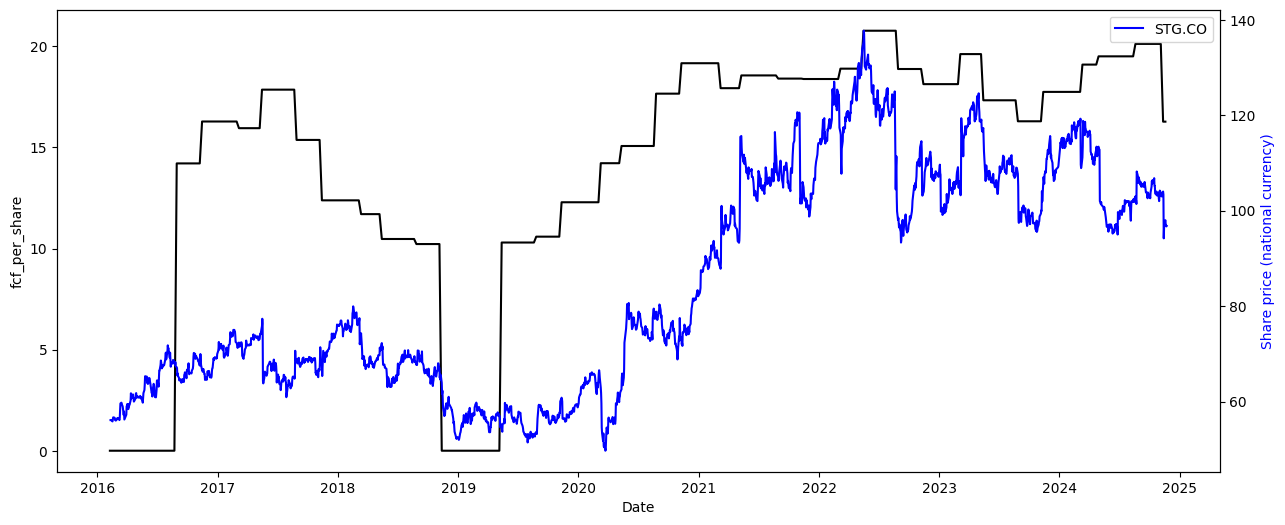

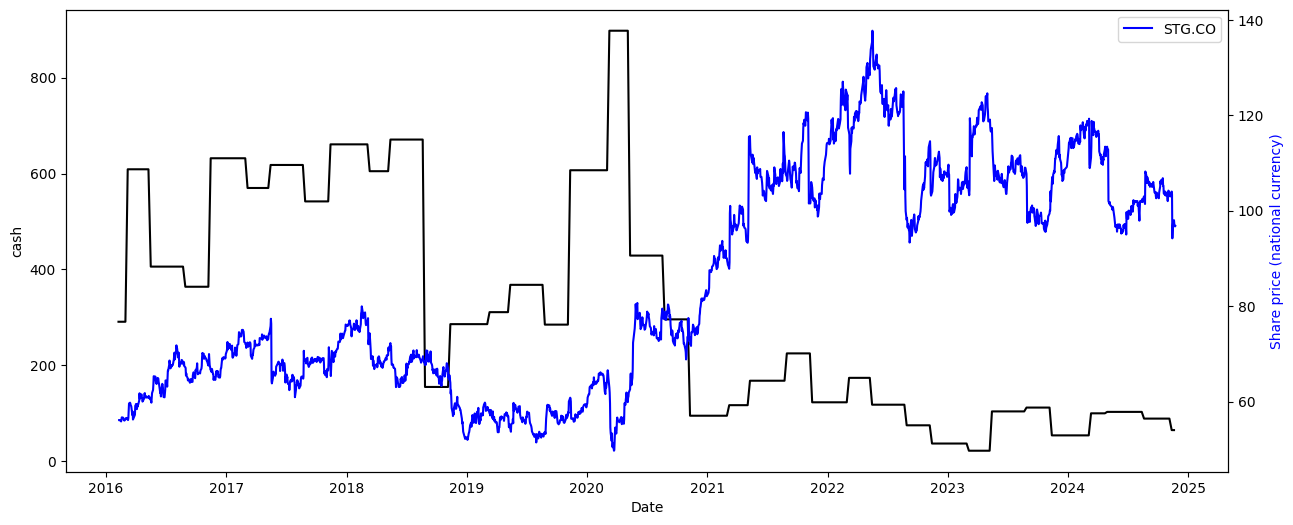

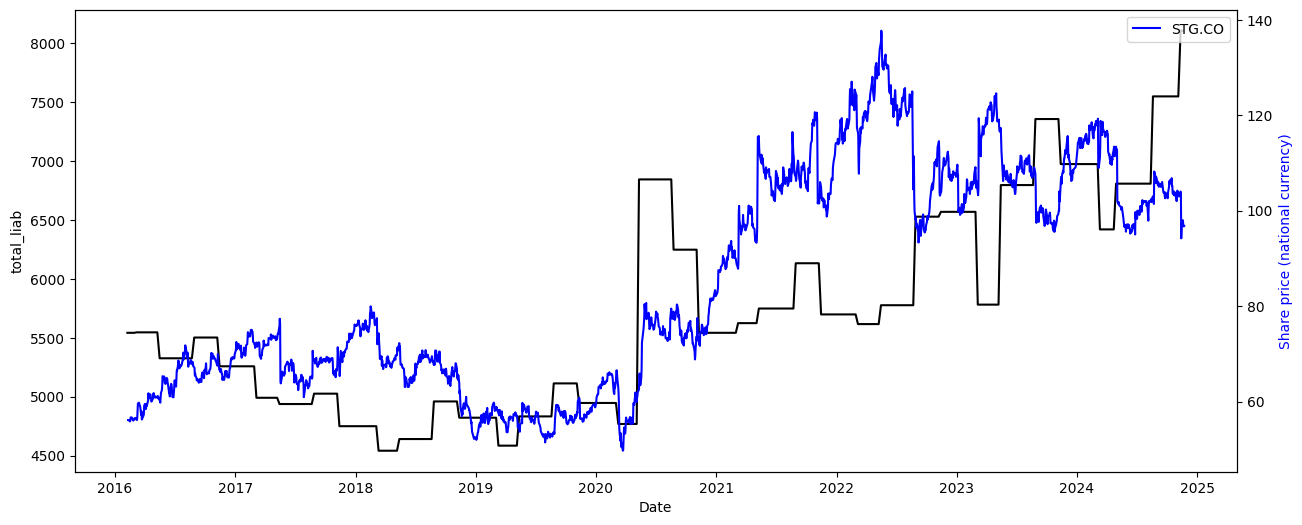

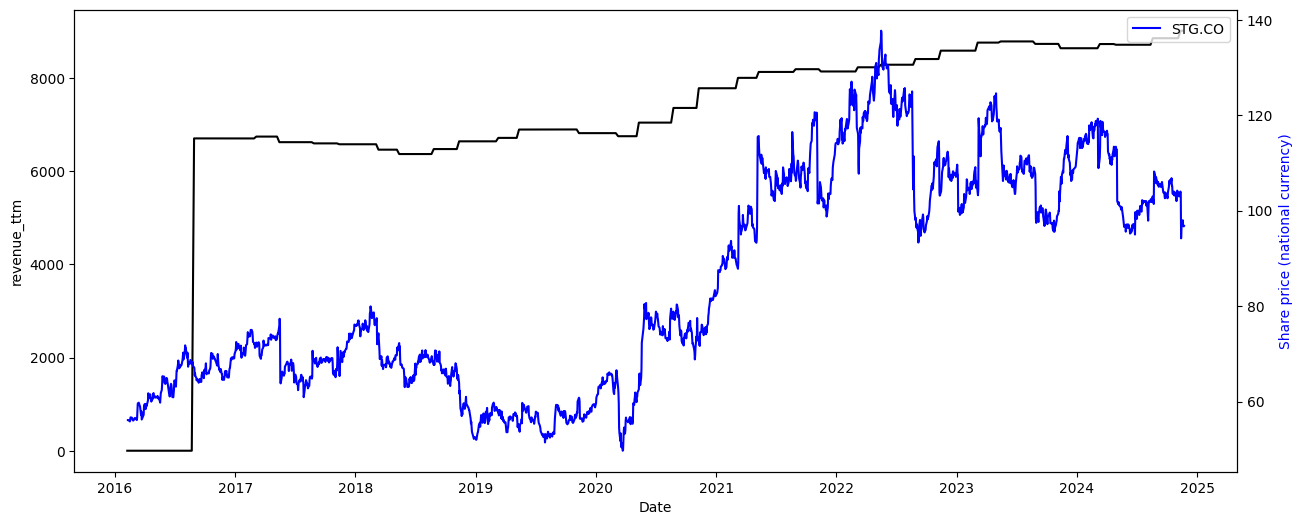

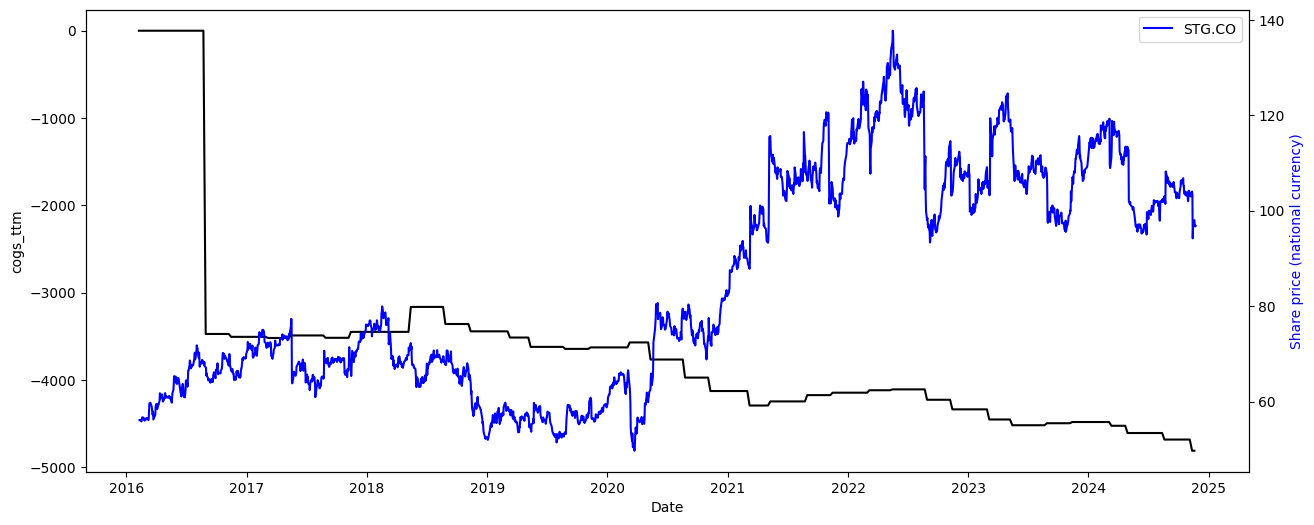

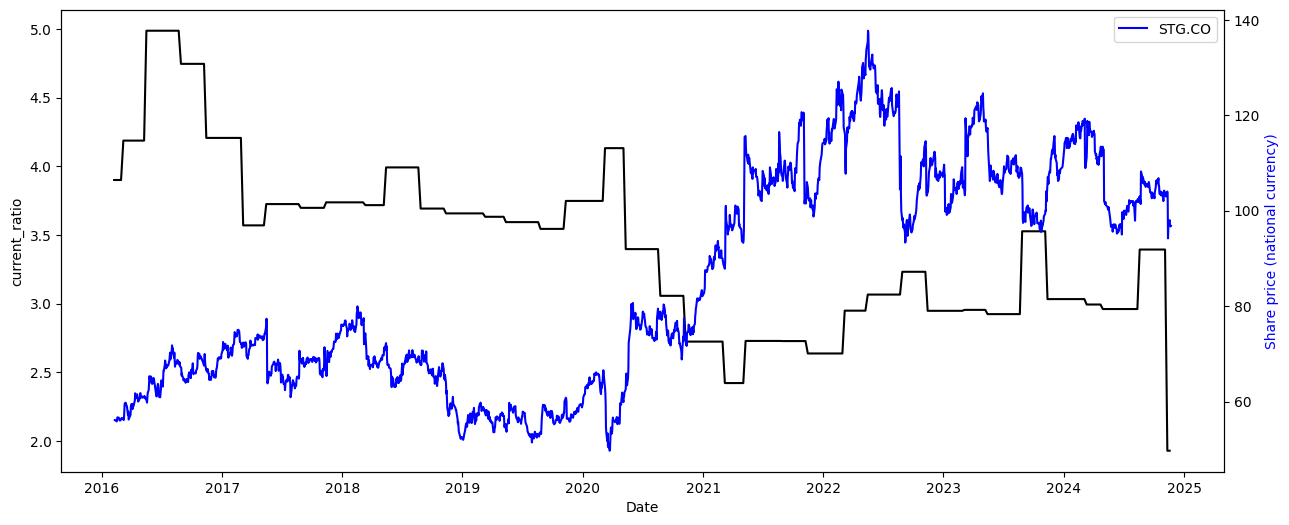

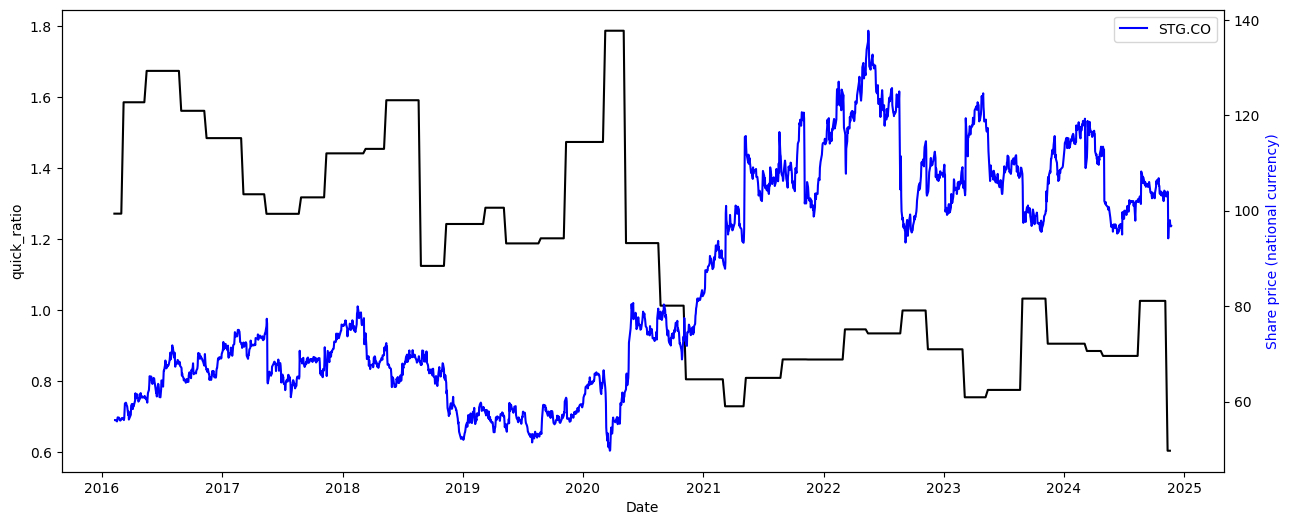

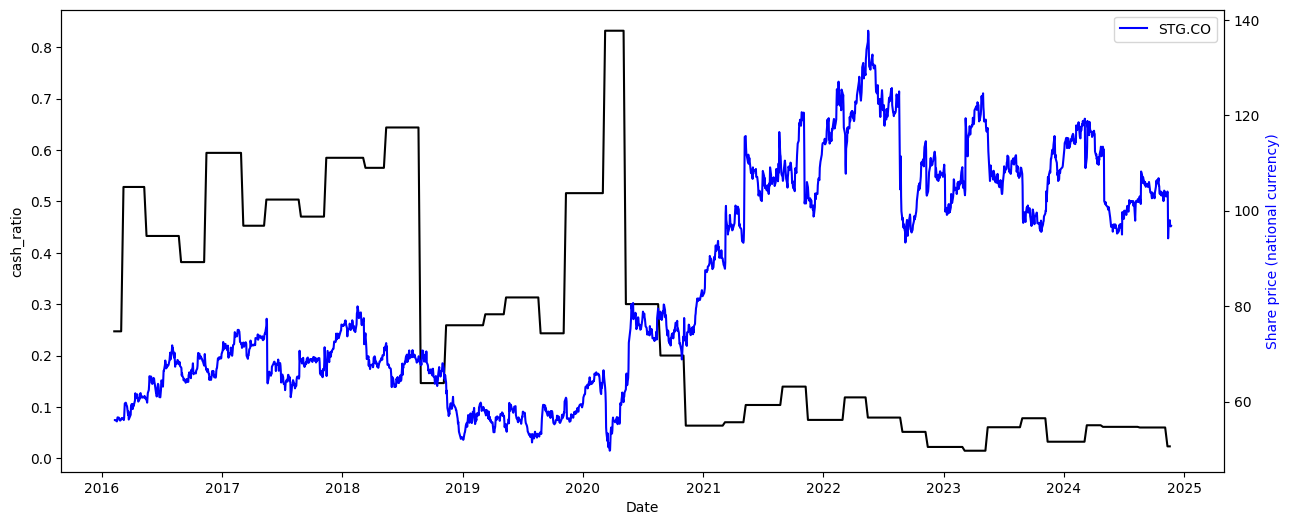

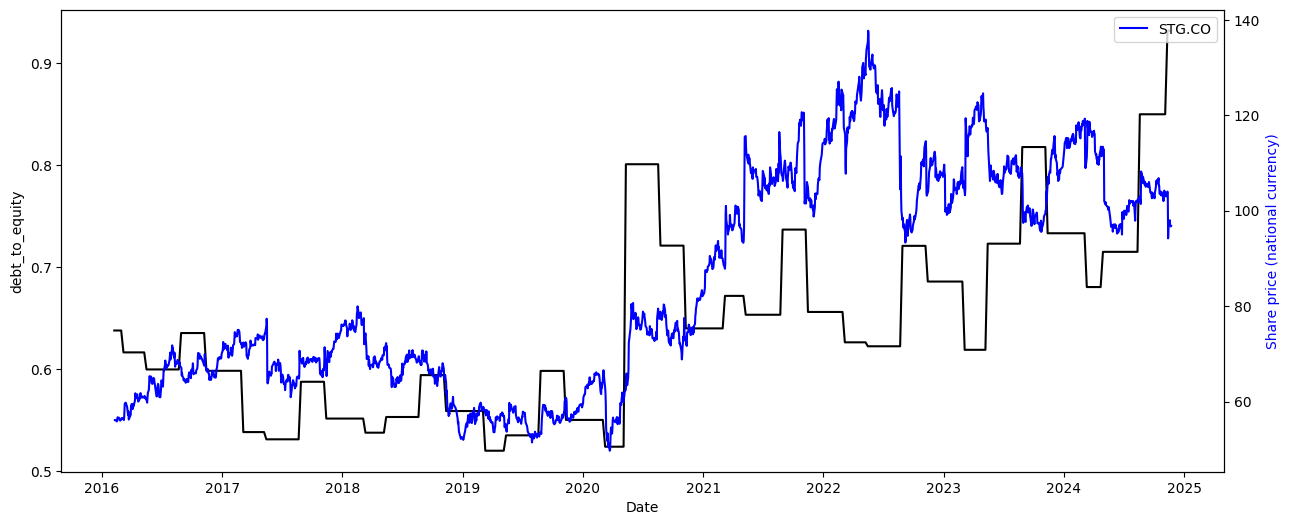

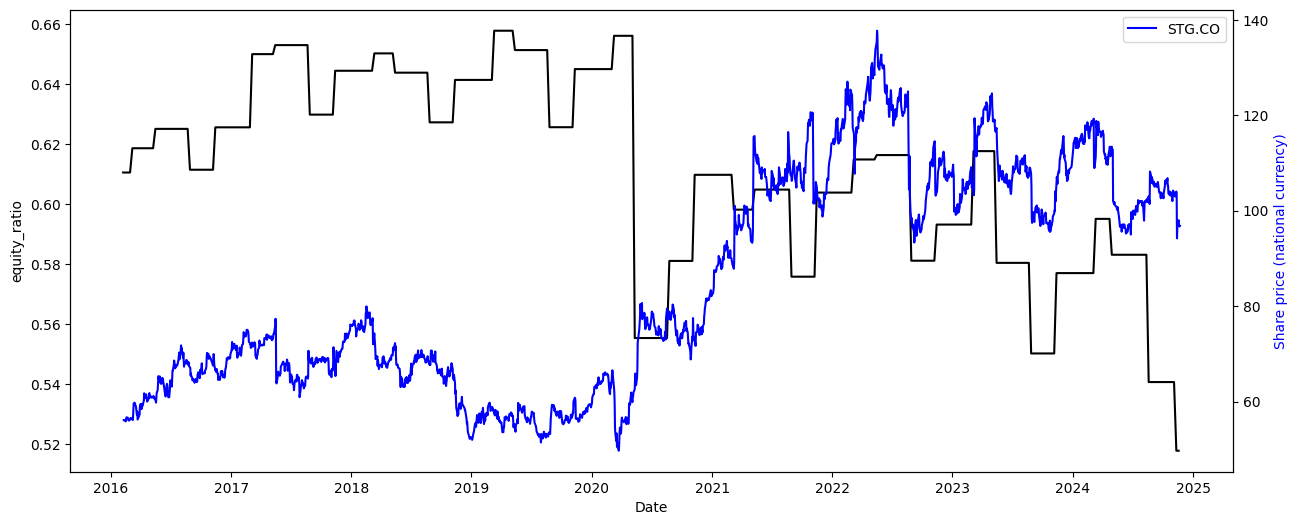

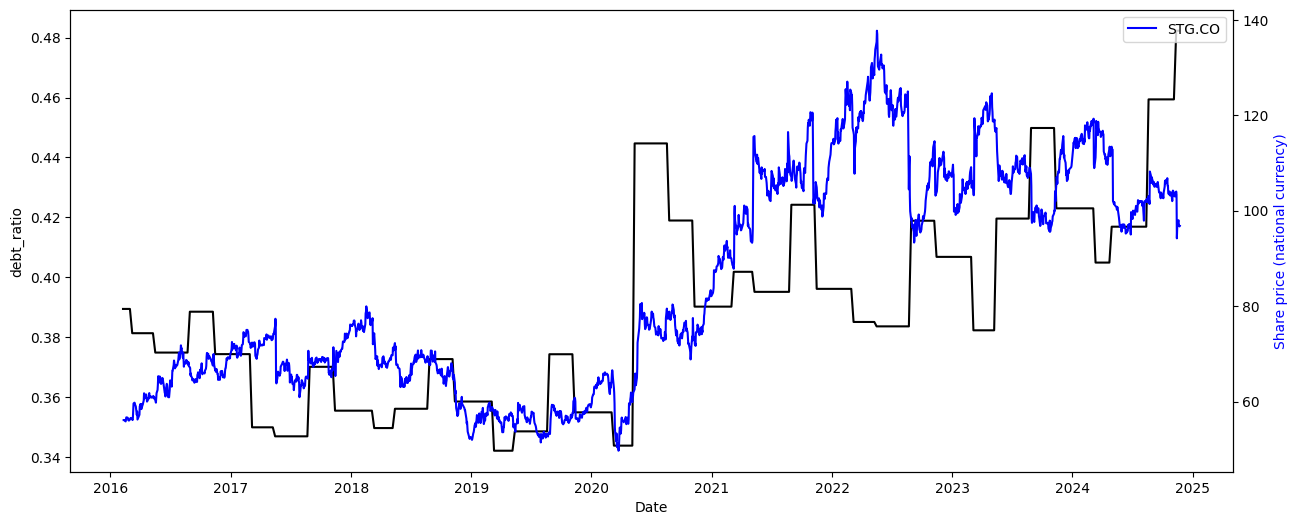

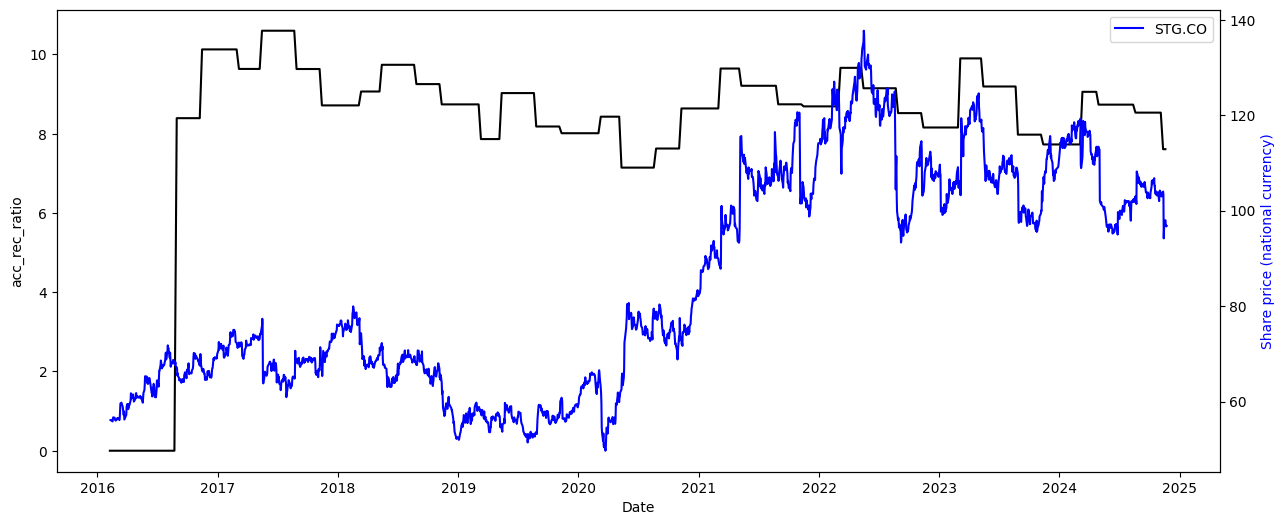

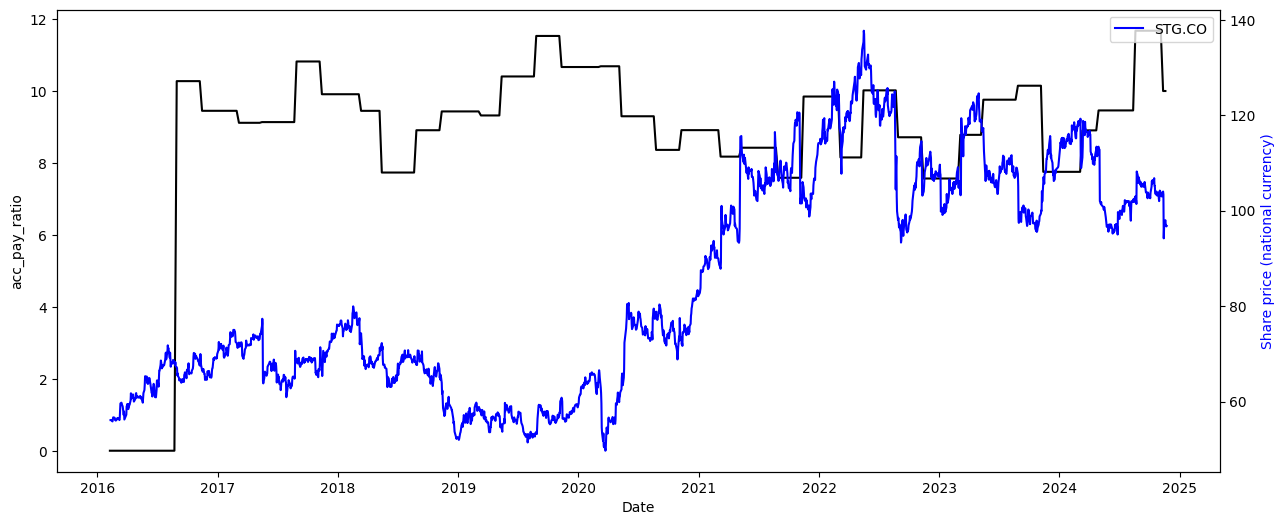

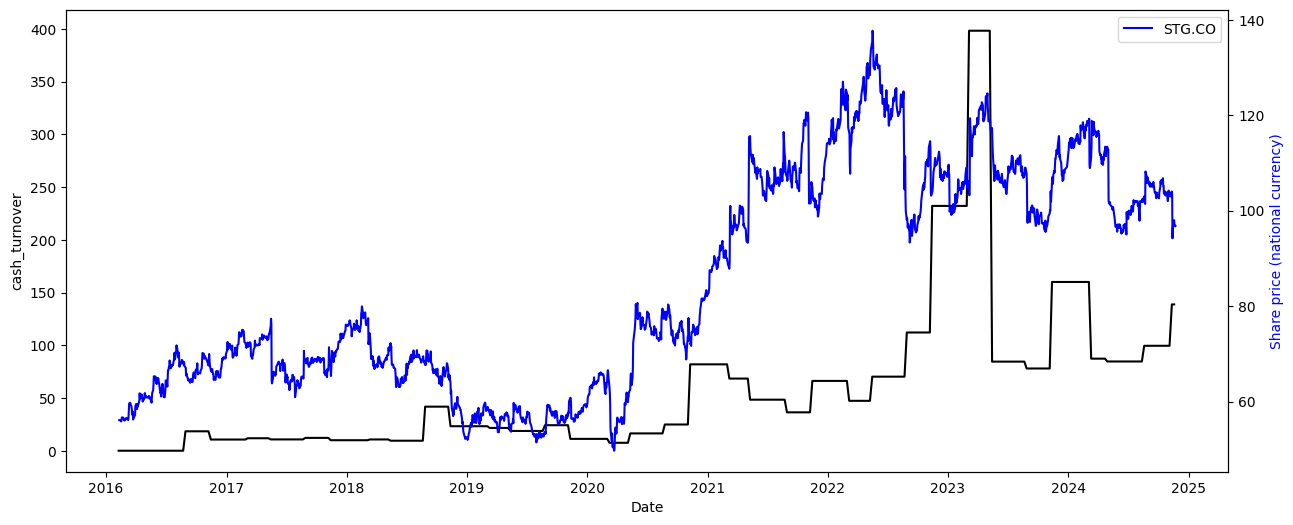

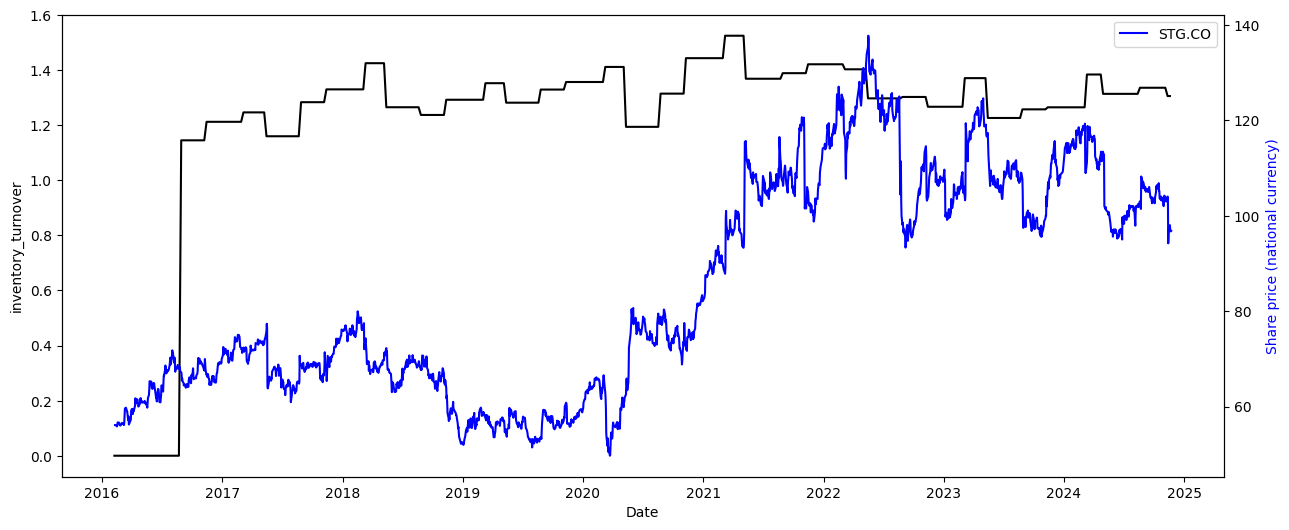

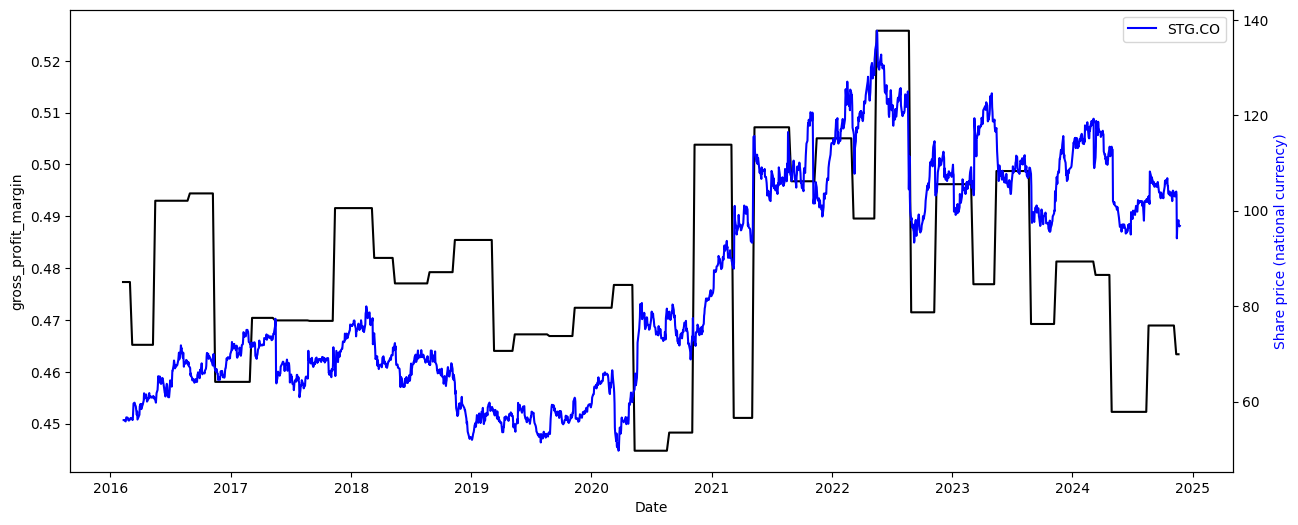

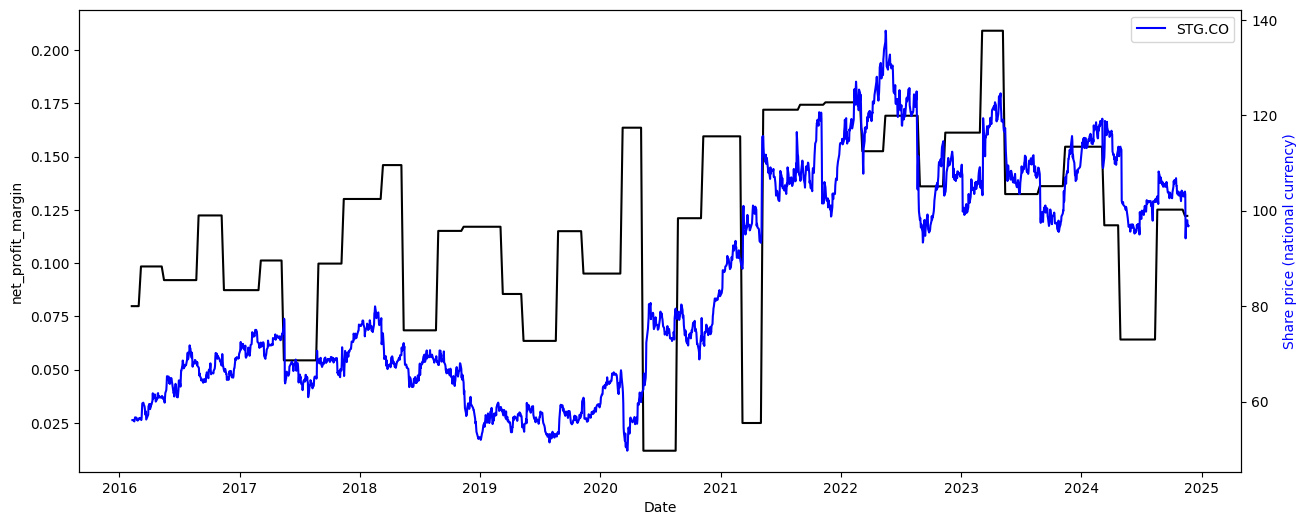

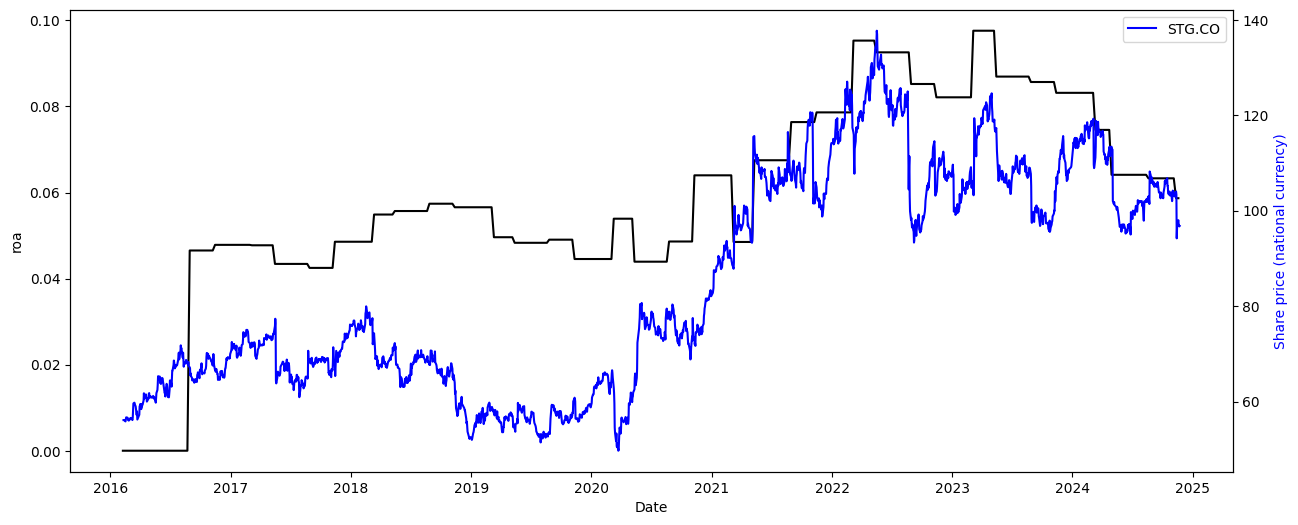

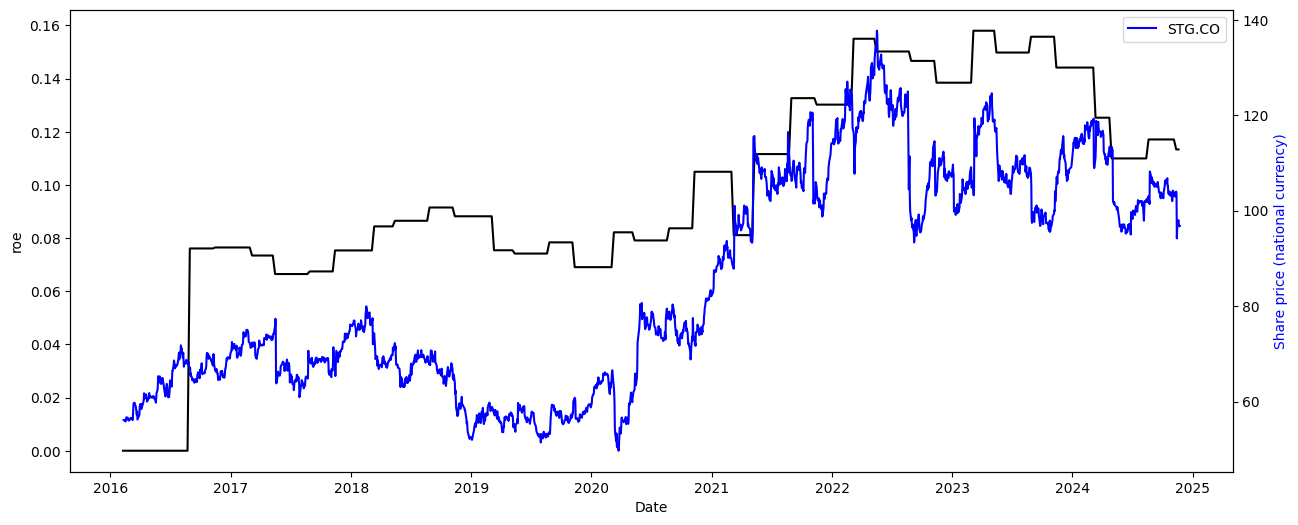

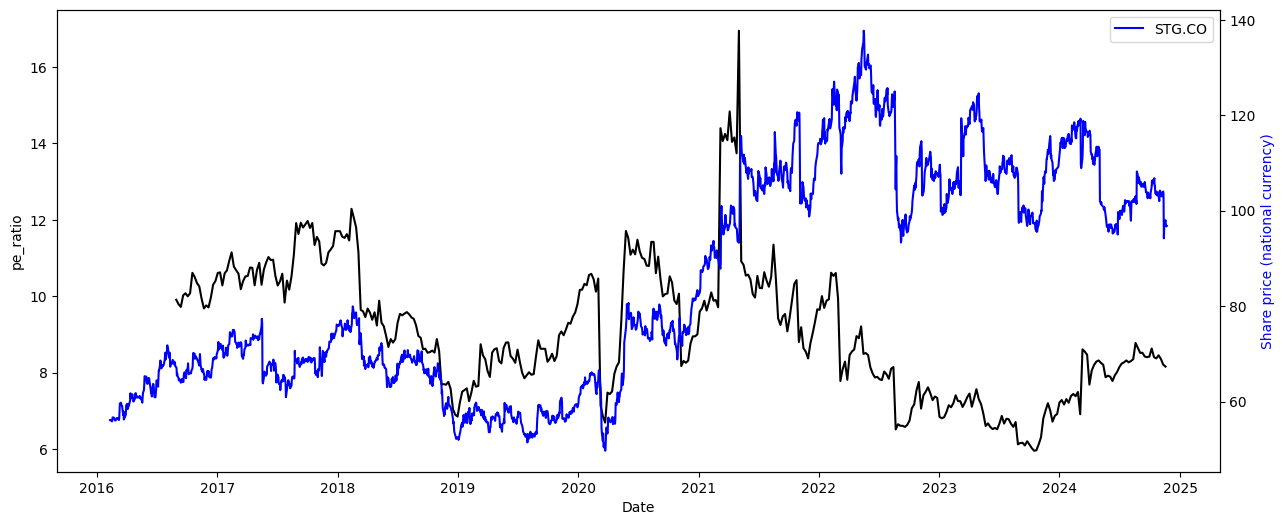

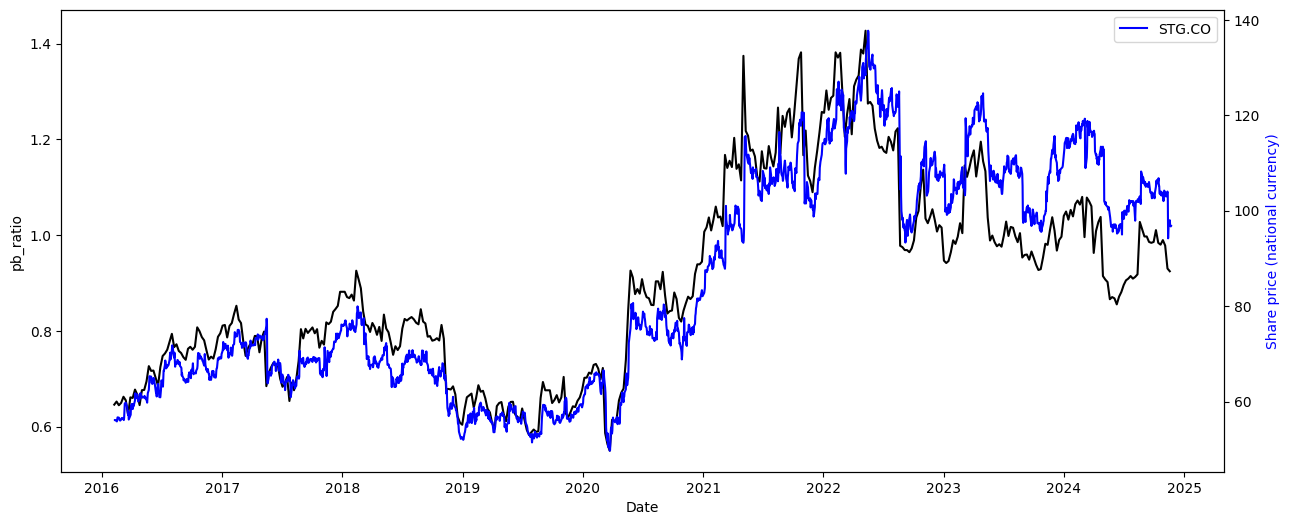

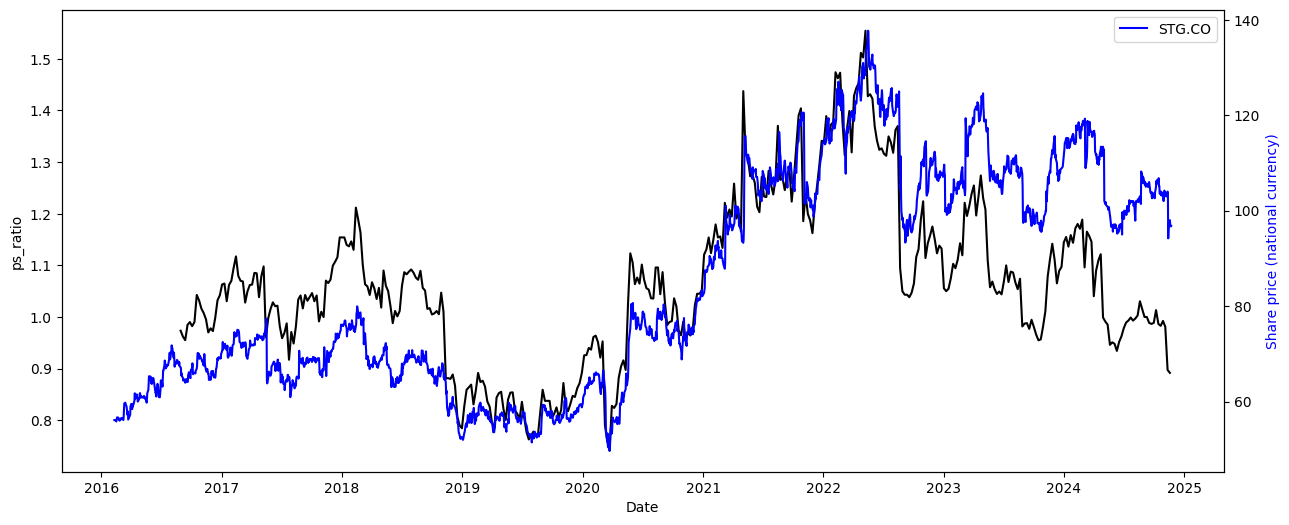

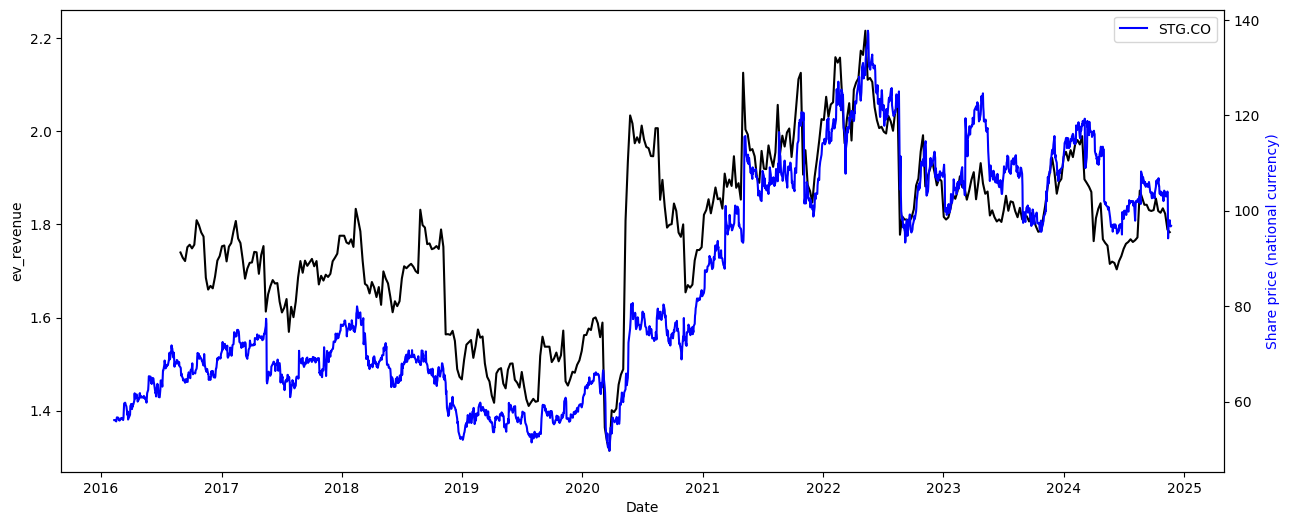

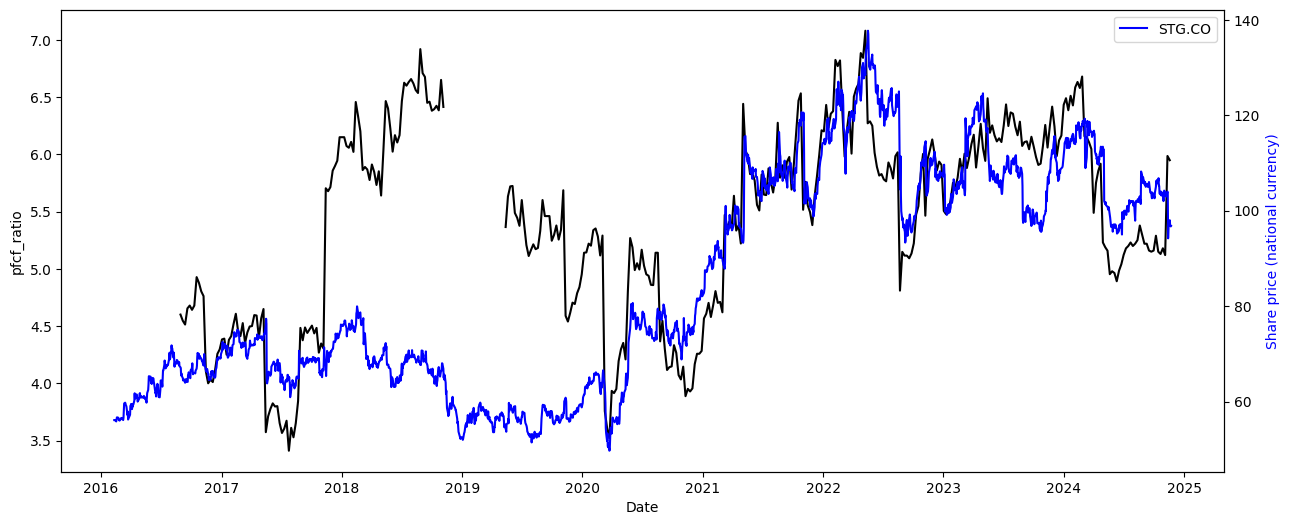

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

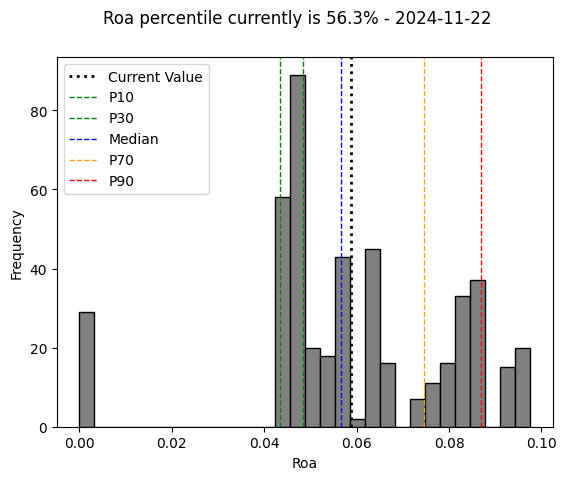

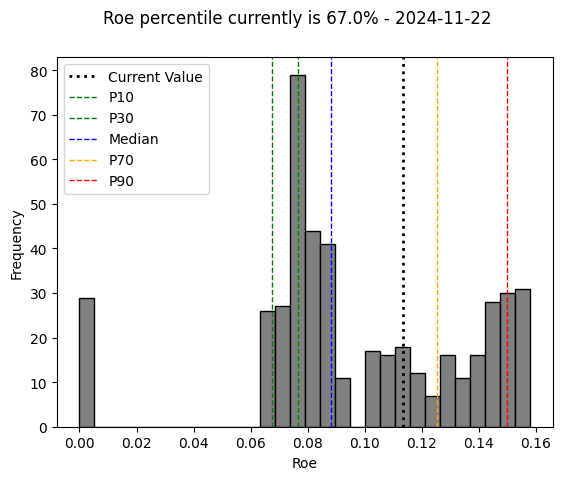

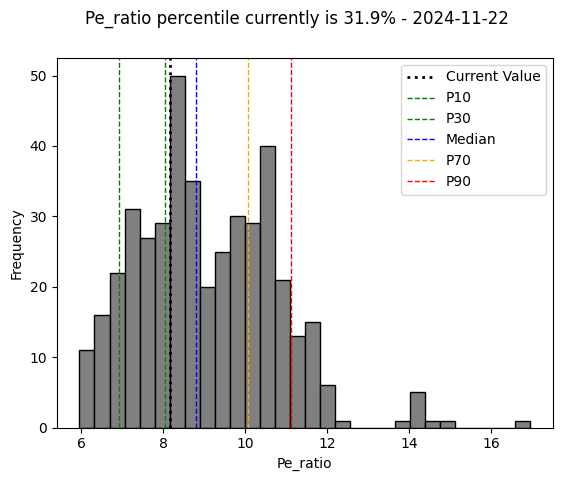

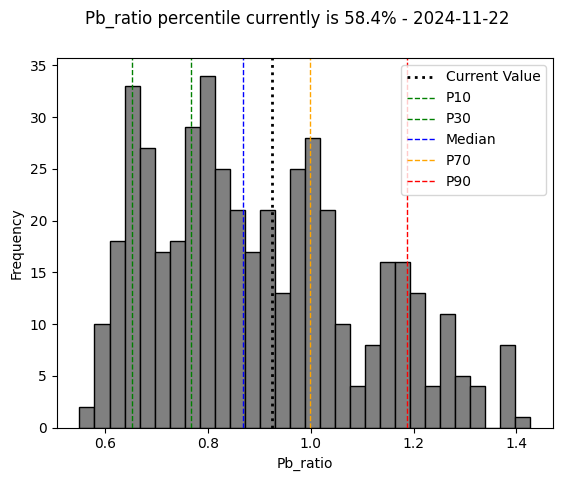

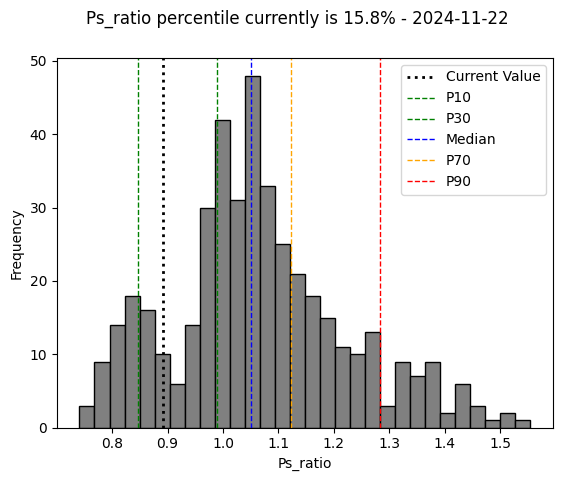

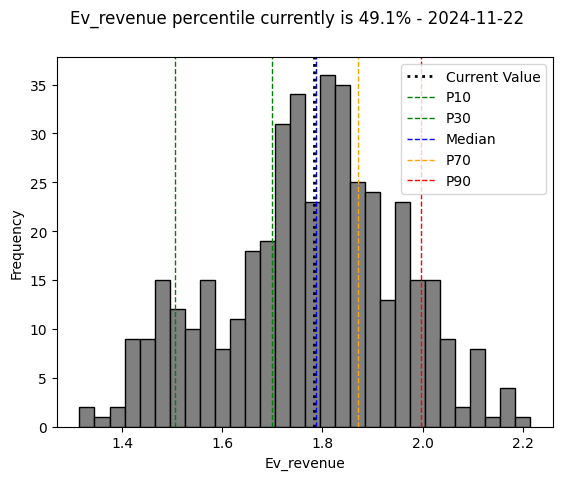

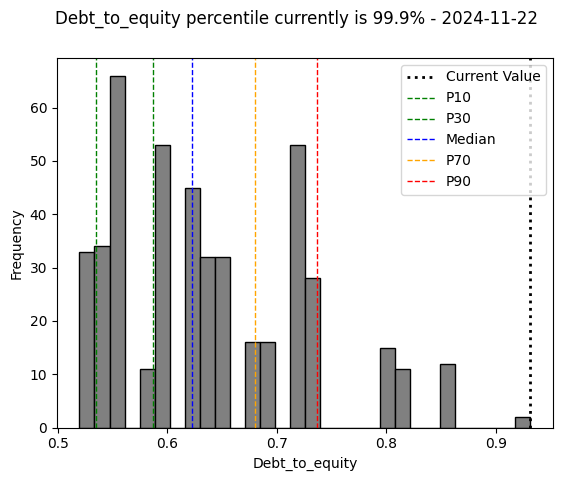

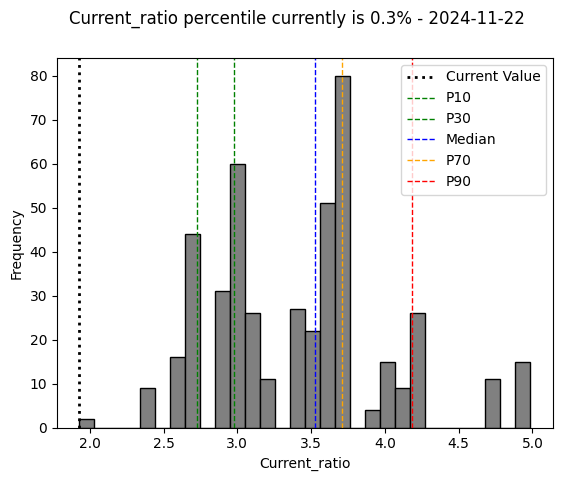

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.991778,-0.636882,0.698122,0.590072,0.614508,0.369041,-0.702526
roe,0.991778,1.000000,-0.631006,0.721194,0.568160,0.651978,0.481521,-0.717316
pe_ratio,-0.636882,-0.631006,1.000000,0.003587,0.210189,0.104370,-0.228049,0.107080
pb_ratio,0.698122,0.721194,0.003587,1.000000,0.924382,0.924465,0.507092,-0.715160
ps_ratio,0.590072,0.568160,0.210189,0.924382,1.000000,0.906626,0.244215,-0.542089
ev_revenue,0.614508,0.651978,0.104370,0.924465,0.906626,1.000000,0.598965,-0.597217
debt_to_equity,0.369041,0.481521,-0.228049,0.507092,0.244215,0.598965,1.000000,-0.462649
current_ratio,-0.702526,-0.717316,0.107080,-0.715160,-0.542089,-0.597217,-0.462649,1.000000


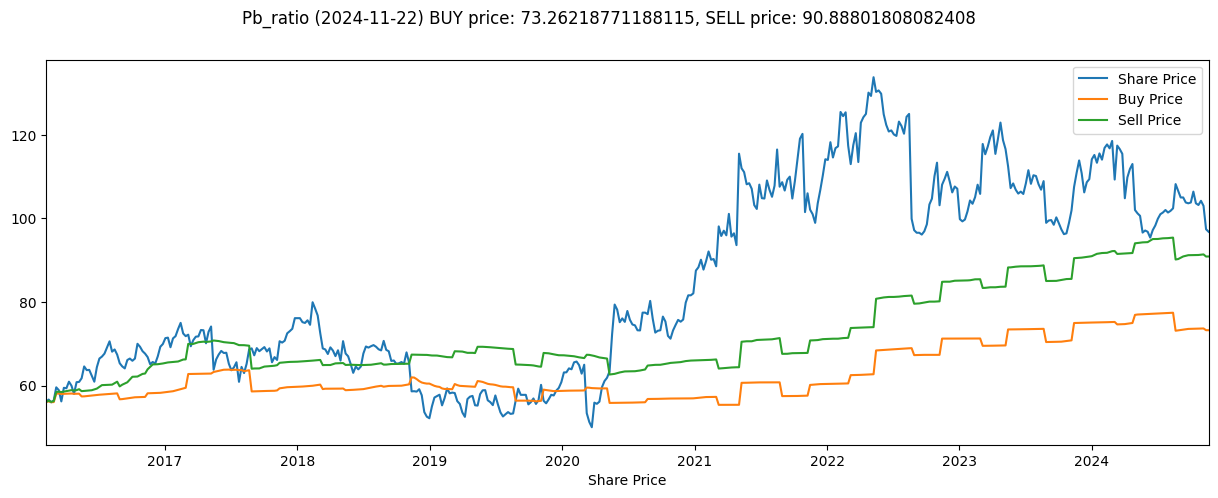

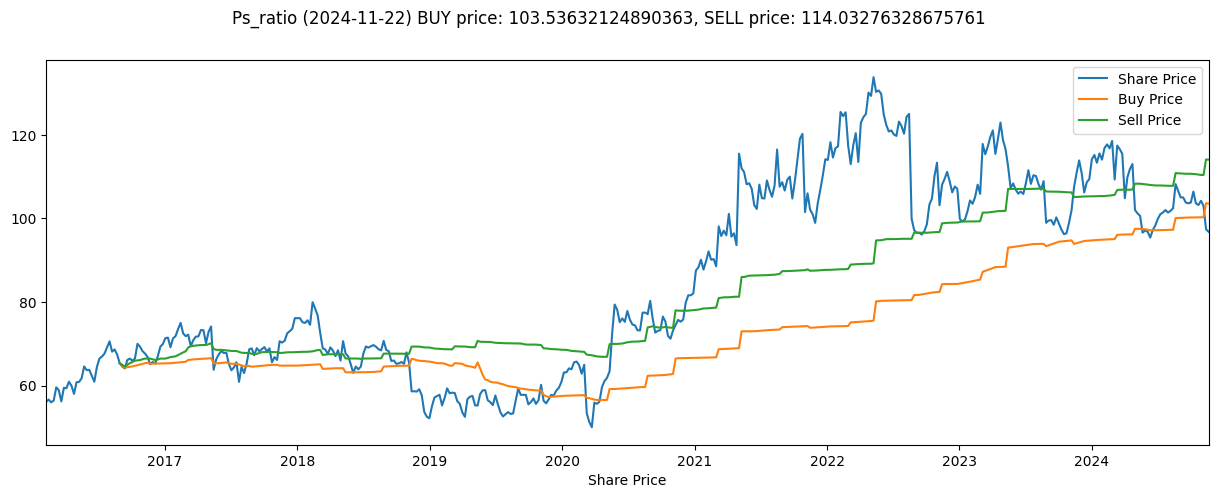

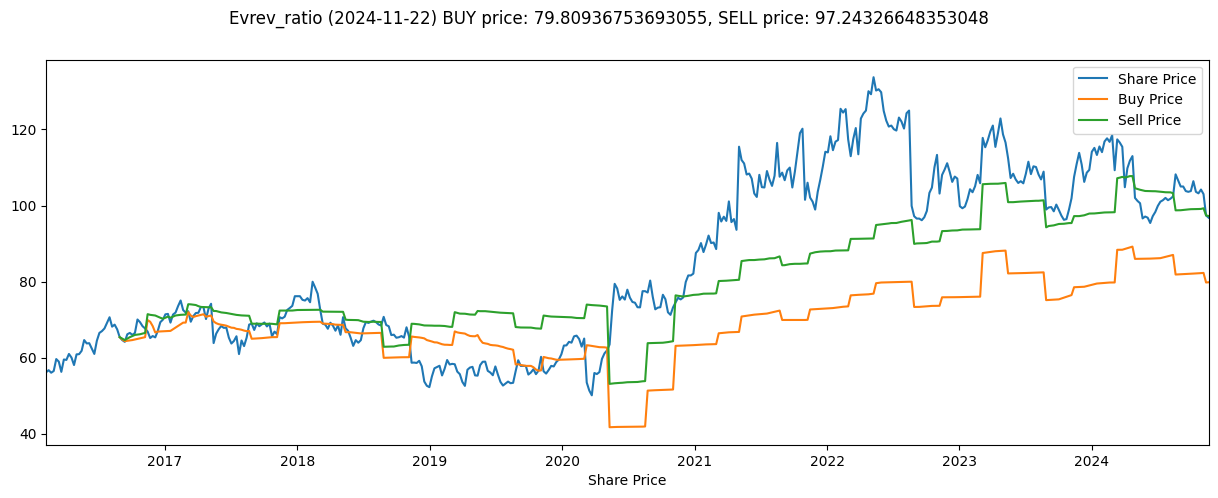

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)